# kaggle chest_x-ray Dataset

### train, test, val 경로 설정 및 파일 갯수 확인

In [1]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models, optimizers
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

Using TensorFlow backend.


findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans.


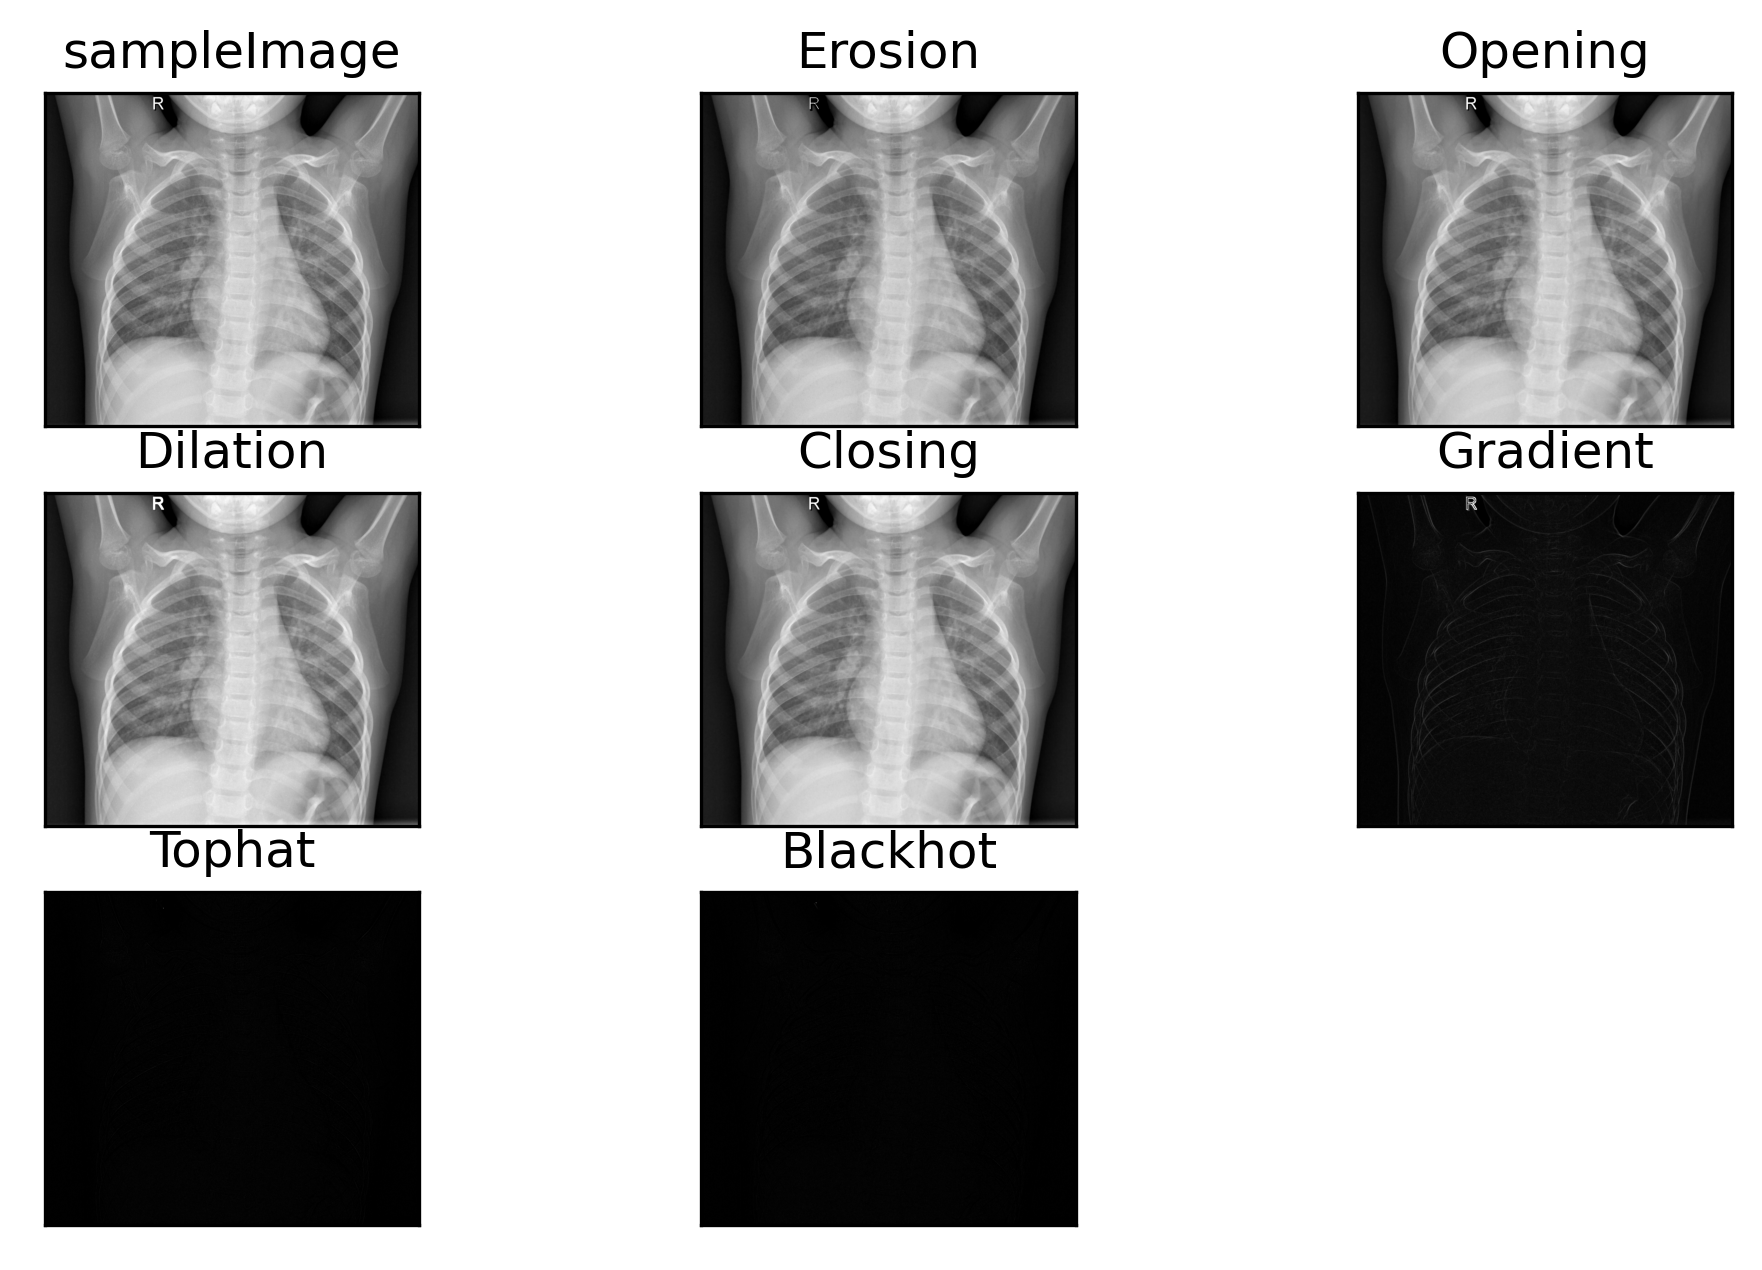

In [10]:
import cv2
import numpy as np

sampleImage = cv2.imread('./train/NORMAL/IM-0115-0001.jpeg')
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

erosion = cv2.erode(sampleImage,kernel,iterations = 1)
dilation = cv2.dilate(sampleImage,kernel,iterations = 1)
opening = cv2.morphologyEx(sampleImage, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(sampleImage, cv2.MORPH_CLOSE,kernel)
gradient = cv2.morphologyEx(sampleImage, cv2.MORPH_GRADIENT, kernel)
tophat = cv2.morphologyEx(sampleImage, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(sampleImage, cv2.MORPH_BLACKHAT, kernel)

images =[sampleImage, erosion, opening, dilation, closing, gradient, tophat, blackhat]
titles =['sampleImage','Erosion','Opening','Dilation','Closing', 'Gradient', 'Tophat','Blackhot']

for i in range(8):
    plt.subplot(3,3,i+1),plt.imshow(images[i]),plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

In [20]:
train_dir = './train'
test_dir = './test'
val_dir = './val'

train_normal_dir = './train/NORMAL'
validation_normal_dir = './test/NORMAL'
test_normal_dir = './val/NORMAL'

train_pneumonia_dir = './train/PNEUMONIA'
validation_pneumonia_dir = './test/PNEUMONIA'
test_pneumonia_dir = './val/PNEUMONIA'

In [21]:
print("train normal images count : ", len(os.listdir(train_normal_dir)))
print("validation normal images count : ", len(os.listdir(validation_normal_dir)))
print("test normal images count : ", len(os.listdir(test_normal_dir)))
print("\n")
print("train pneumonia images count : ", len(os.listdir(train_pneumonia_dir)))
print("validation pneumonia images count : ", len(os.listdir(validation_pneumonia_dir)))
print("test pneumonia images count : ", len(os.listdir(test_pneumonia_dir)))

train normal images count :  1341
validation normal images count :  234
test normal images count :  8


train pneumonia images count :  3875
validation pneumonia images count :  390
test pneumonia images count :  8


### 데이터 전처리
- 1. read image files
- 2. decode JPEG contents to RGB pixel values
- 3. convert float type tensor
- 4. regulation pixel 0-255 to 0-1
- all above process can be completed by using keras.preprocessing.image especially ImageDataGenerator Class

In [4]:
# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='binary'
# )

# validation_generator = test_datagen.flow_from_directory(
#     val_dir,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='binary'
# )


### 데이터 증식(Data augmentation)

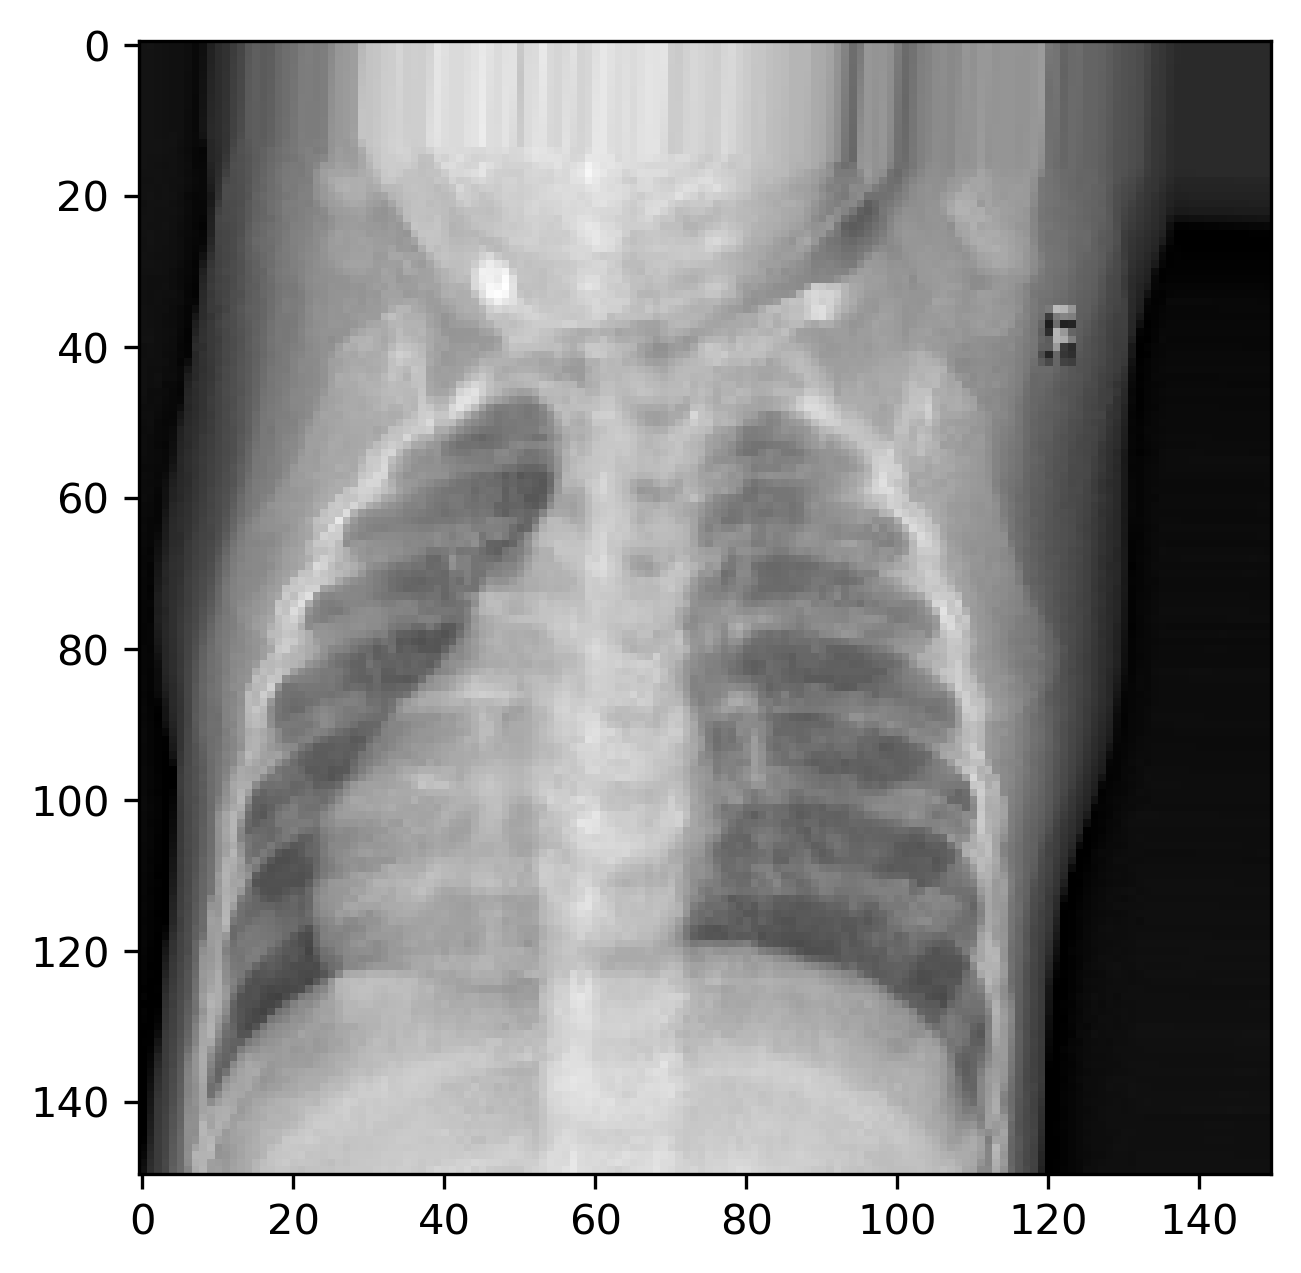

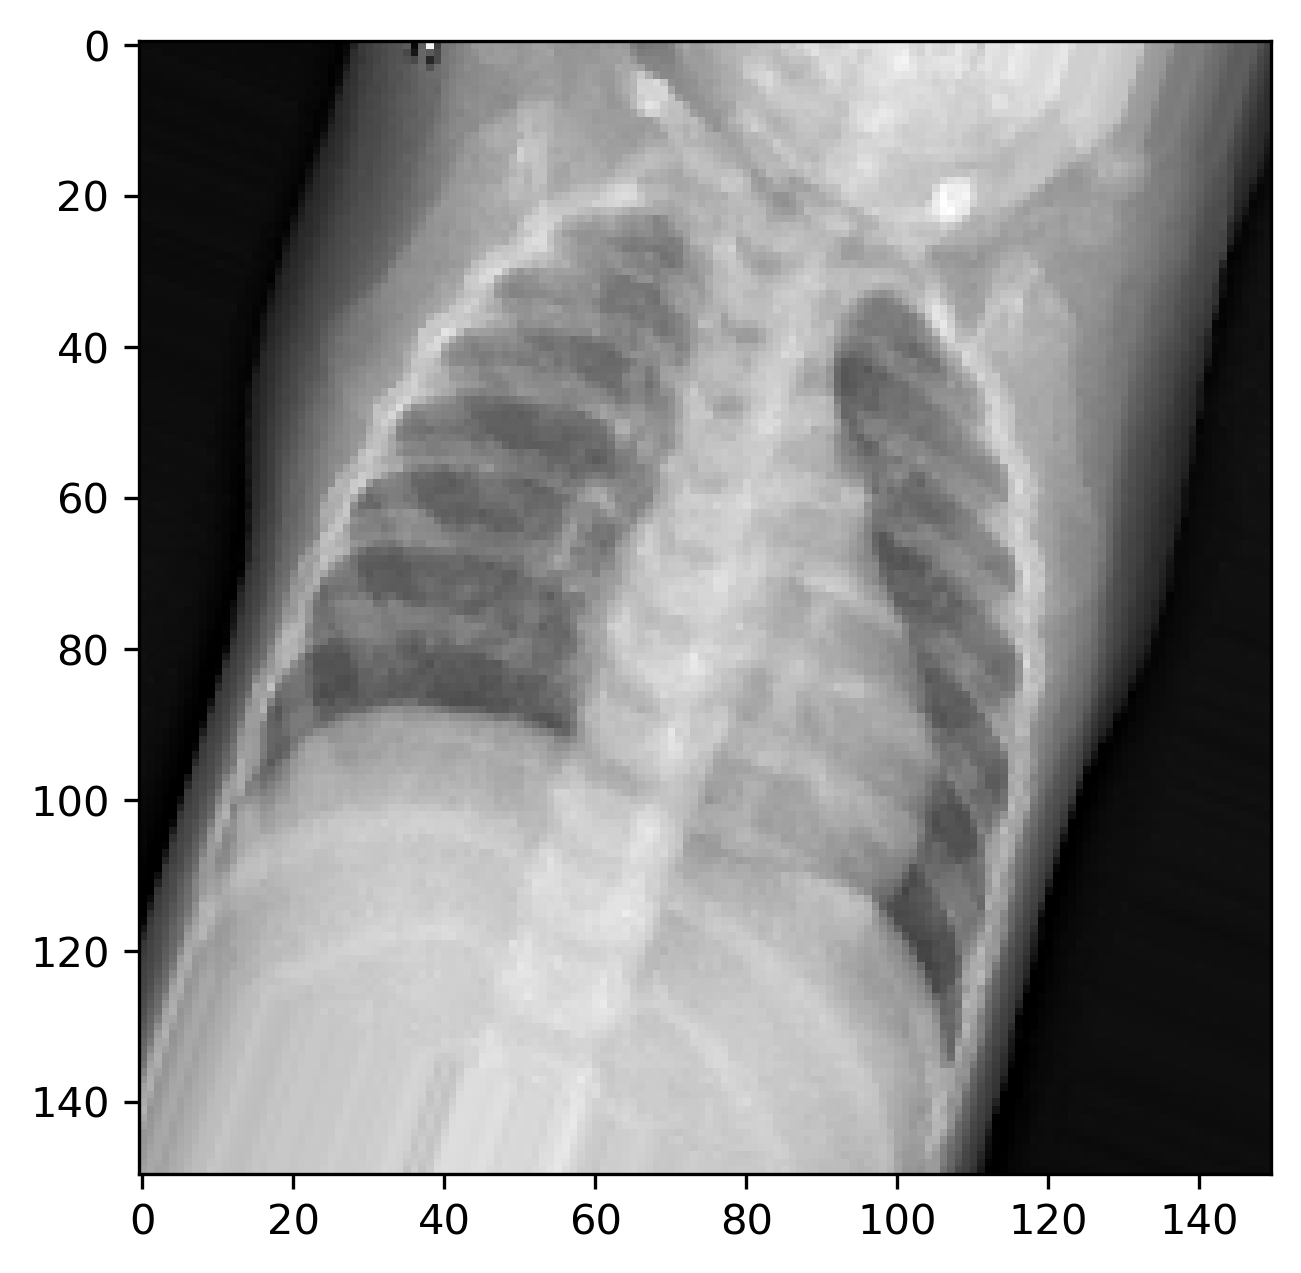

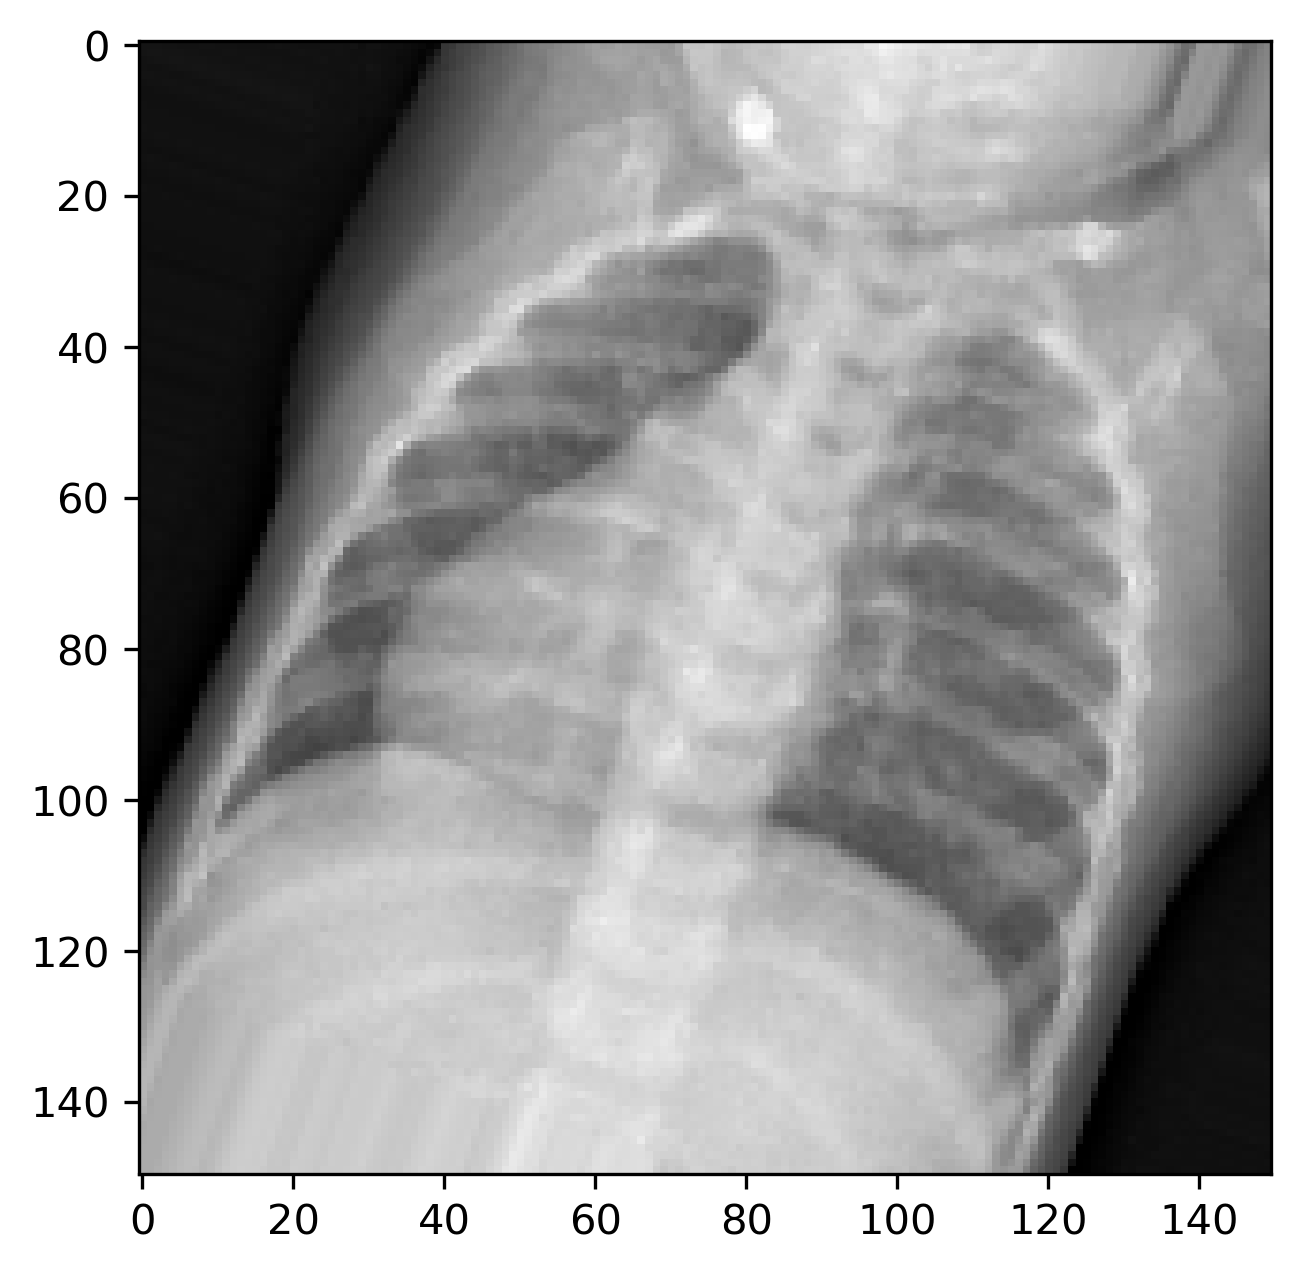

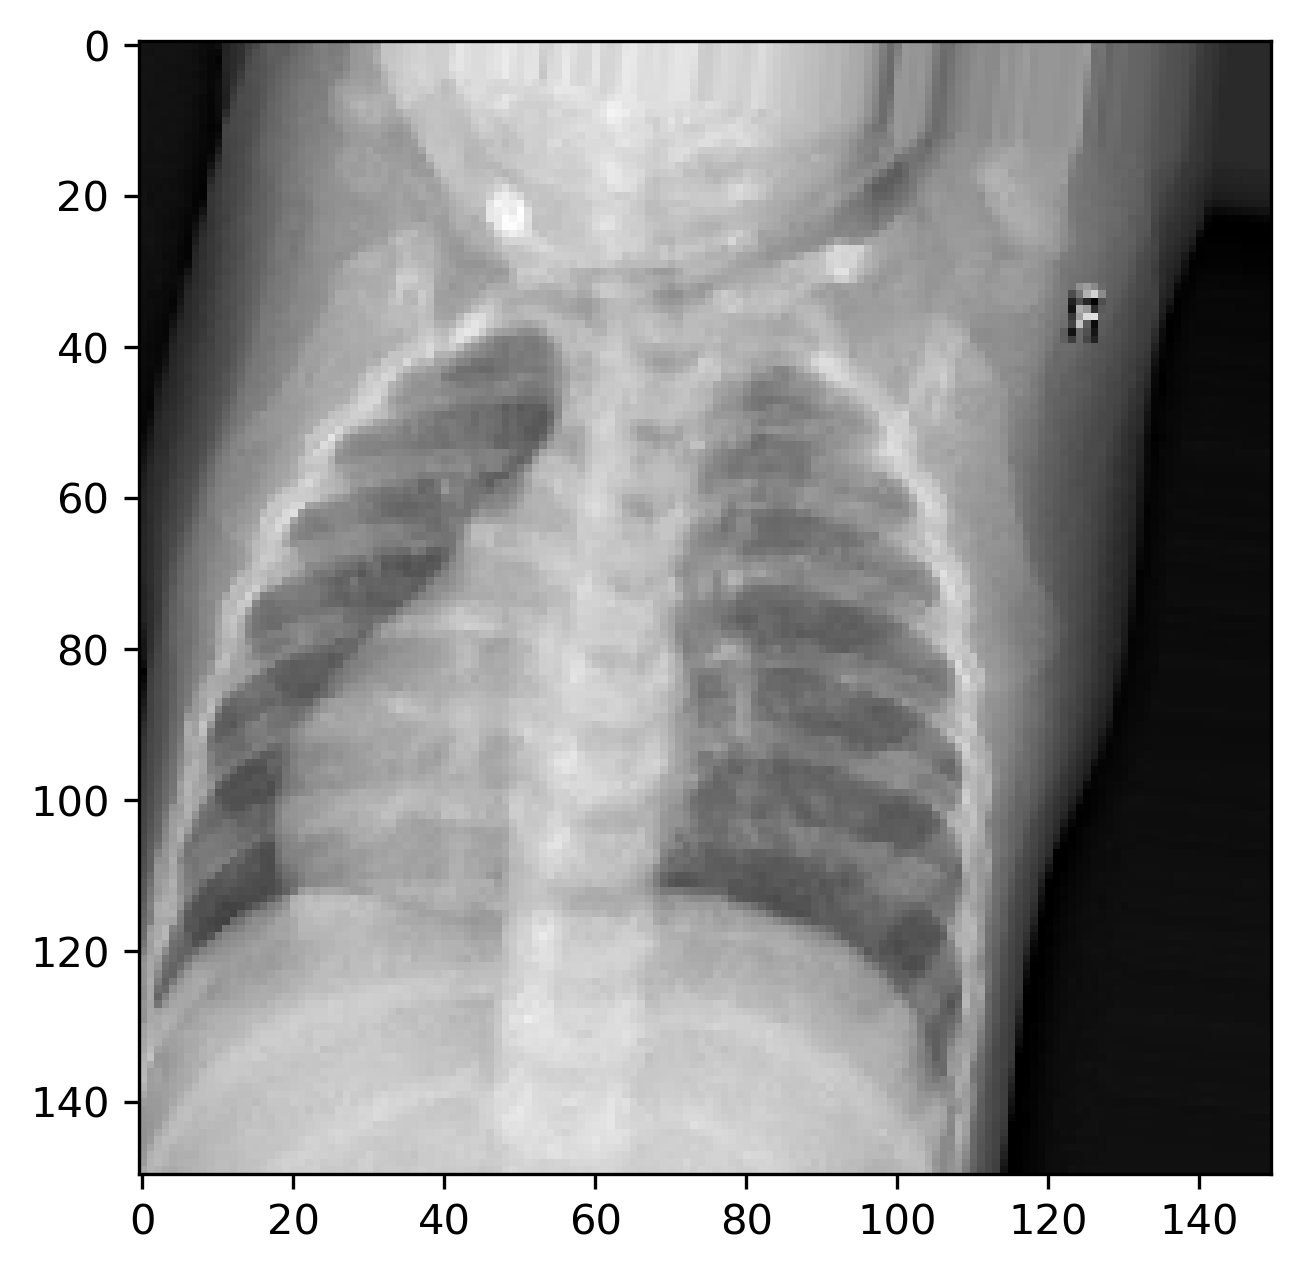

In [22]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

fnames = sorted([os.path.join(train_normal_dir, fname) for fname in os.listdir(train_normal_dir)])
img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))
x=image.img_to_array(img)
x = x.reshape((1,)+x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i%4 == 0:
        break
plt.show()

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255) # 검증데이터는 증식되면안됨!

train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator= test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### 네트워크 구성

In [8]:
# 모델1
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss = 'binary_crossentropy',
             metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
# 모델2
model = models.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 38, 38, 64)        0         
__________

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [27]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=12,
                              validation_data=validation_generator,
                             validation_steps=50)

model.save('chest_x_ray.h5')

Epoch 1/12
100/100 [==============================] - 253s 3s/step - loss: 4.0572 - acc: 0.7406 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/12
100/100 [==============================] - 259s 3s/step - loss: 4.0952 - acc: 0.7431 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/12
100/100 [==============================] - 258s 3s/step - loss: 4.1400 - acc: 0.7403 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/12
  4/100 [>.............................] - ETA: 4:12 - loss: 4.6083 - acc: 0.7109

KeyboardInterrupt: 

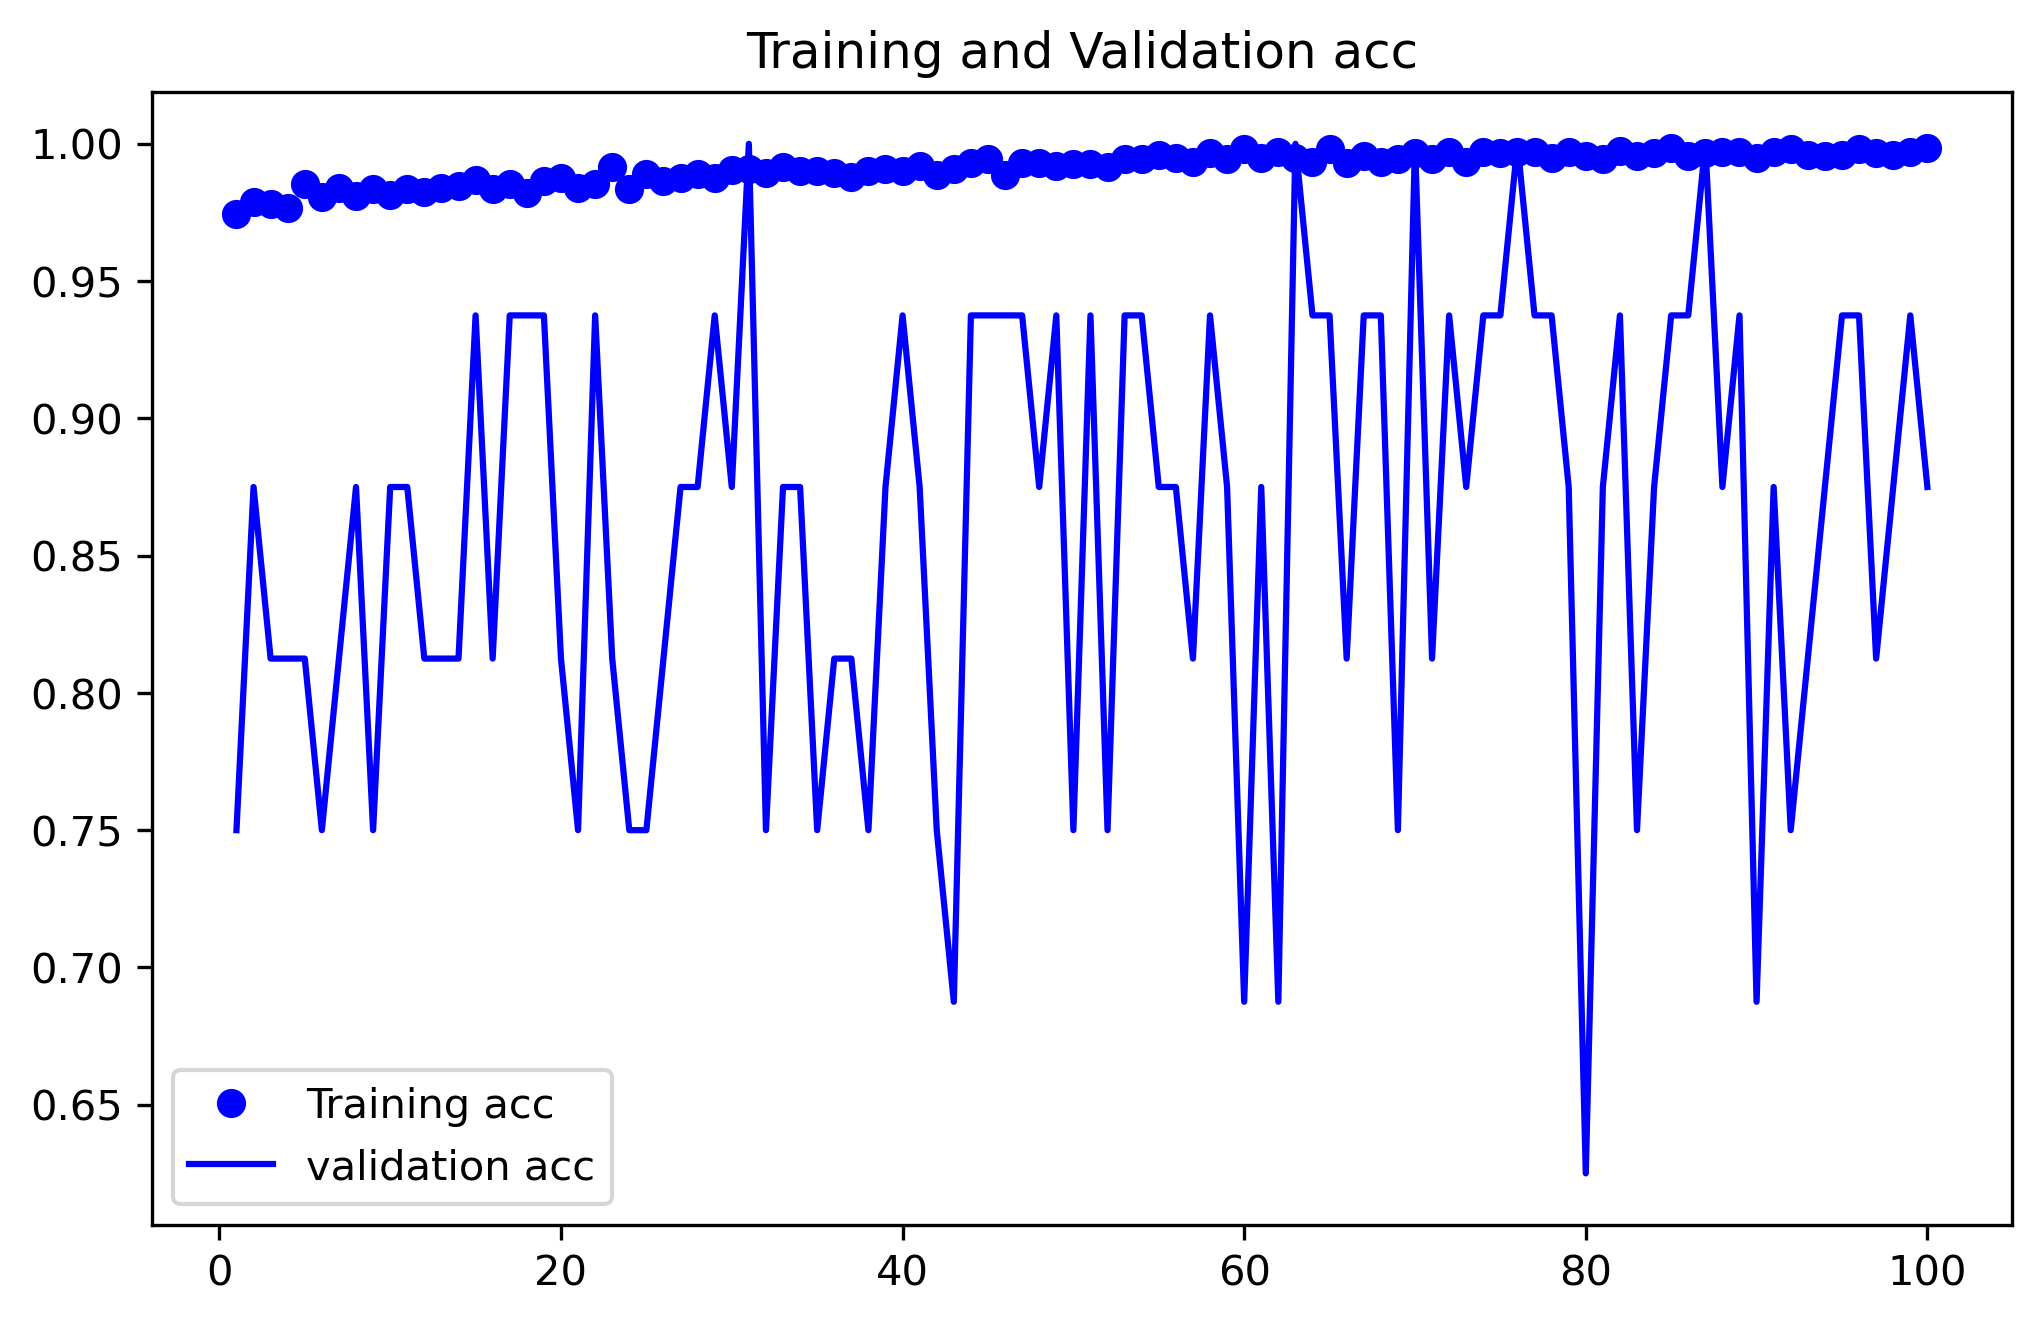

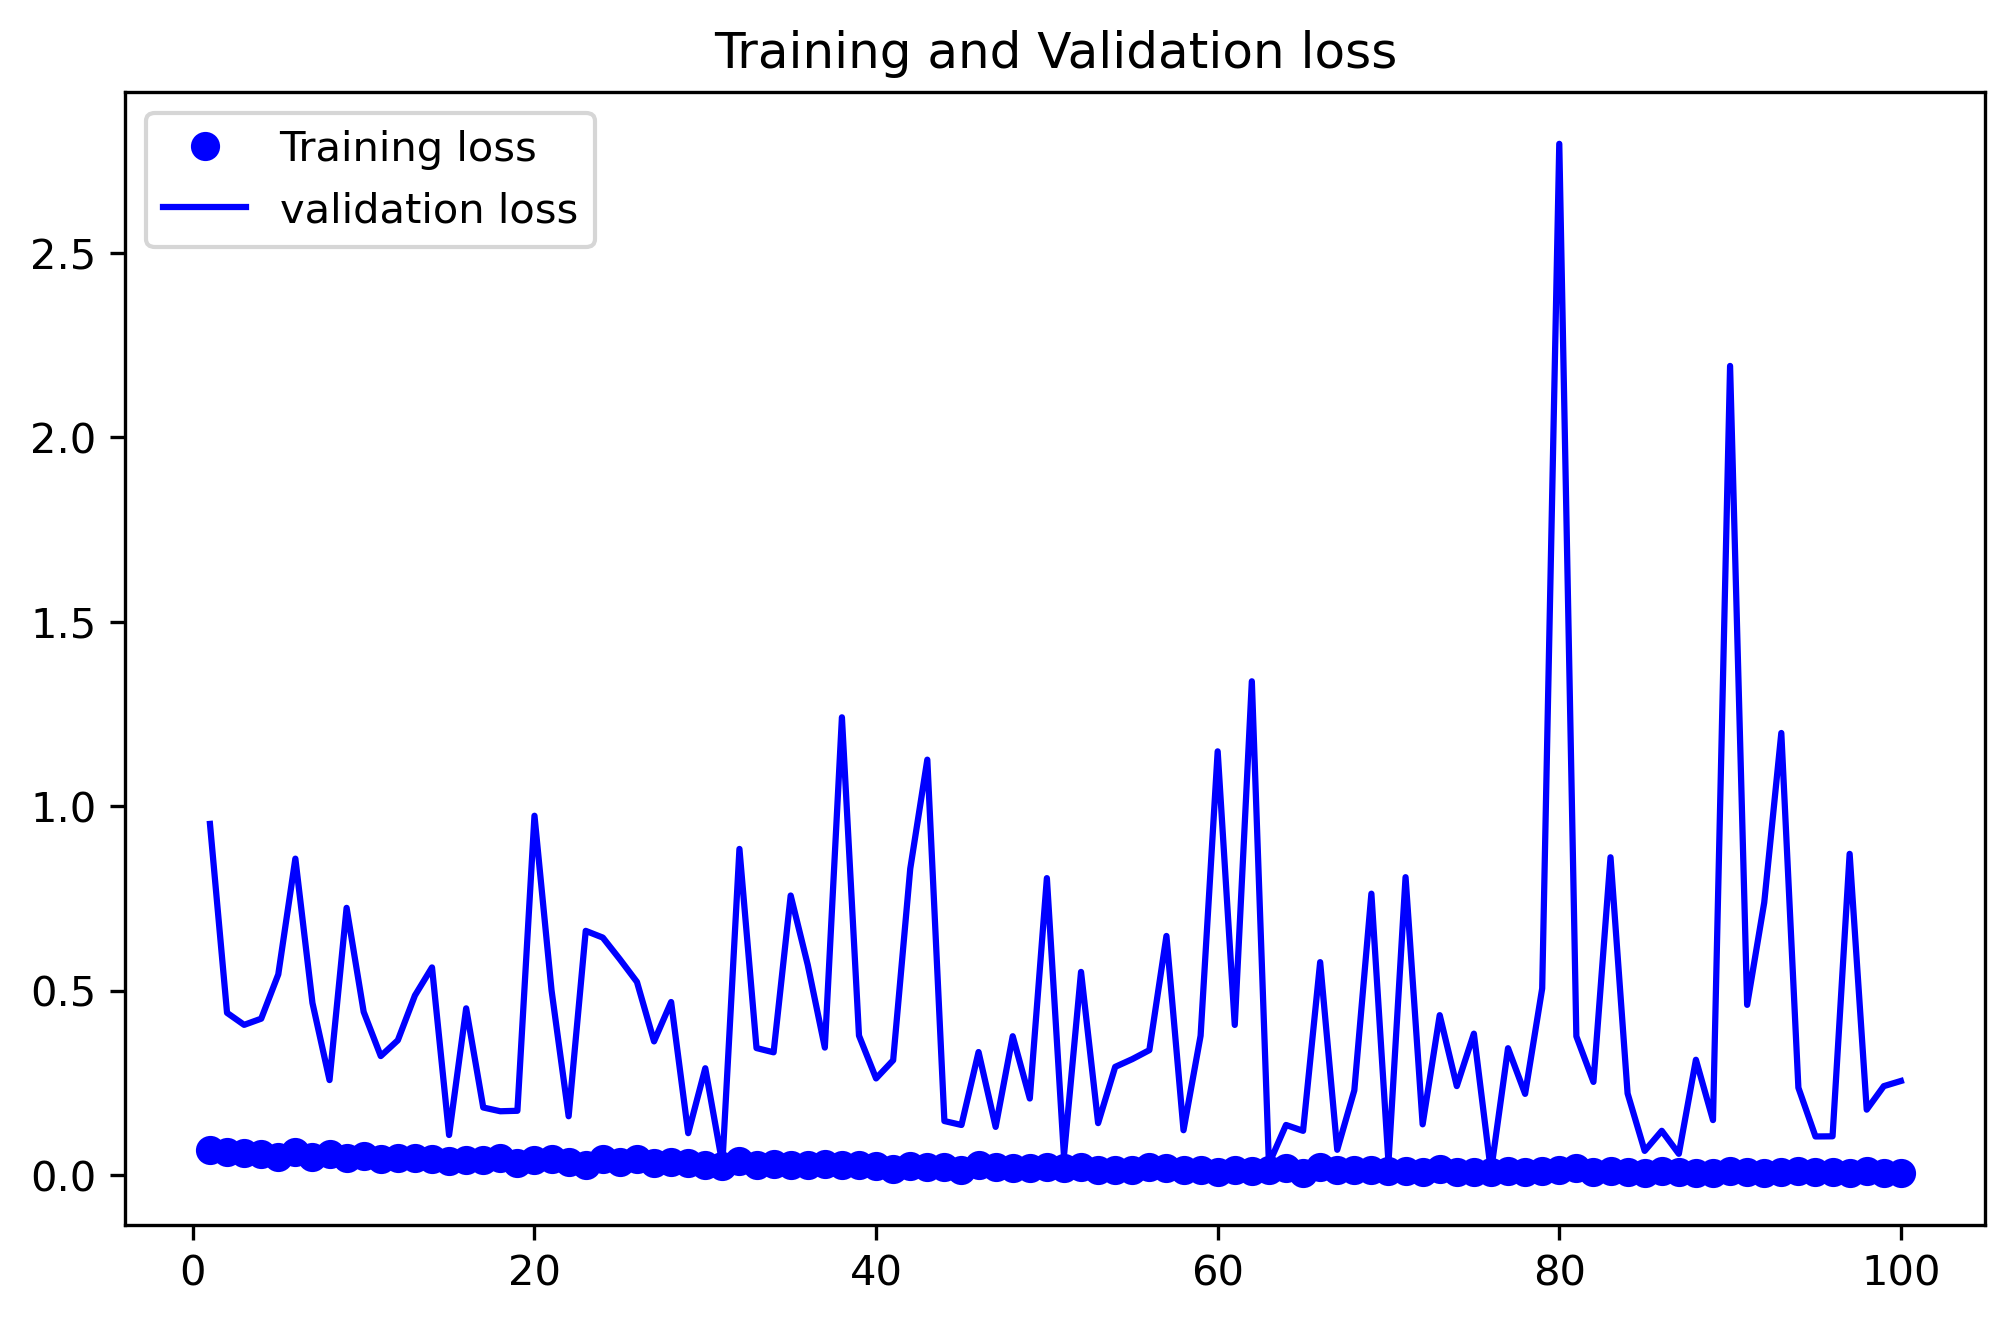

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.legend()

plt.figure()

plt.ylim
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [22]:
# 테스트
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc : ', test_acc)

Found 624 images belonging to 2 classes.
test acc :  0.760162603806674


# Test Result Log
- 데이터 전처리 추가 : 0.7551
- 데이터 증식 추가 : 0.760162603806674